In [1]:
import os
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from collections import Counter
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords

import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import GPT2TokenizerFast, ViTFeatureExtractor
from transformers import VisionEncoderDecoderModel
from transformers import Trainer, TrainingArguments
from transformers import default_data_collator
import os

In [2]:
df = pd.read_csv("./Dataset/captions.txt")
df

,Image Name,Caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [3]:
img_path = './Dataset/Images/'

df['Image Name'] = img_path + df['Image Name']
df


,Image Name,Caption
0,./Dataset/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,./Dataset/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,./Dataset/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,./Dataset/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,./Dataset/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,./Dataset/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [4]:
# import cv2
# x = cv2.imread(df['Image Name'][100])
# cv2.imshow('Image', x)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

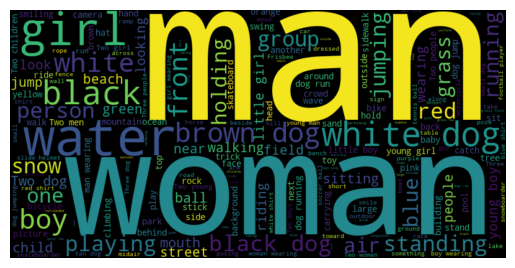

In [5]:
words = " ".join(df['Caption'].values)
wordcloud = WordCloud(width=800, height=400).generate(words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


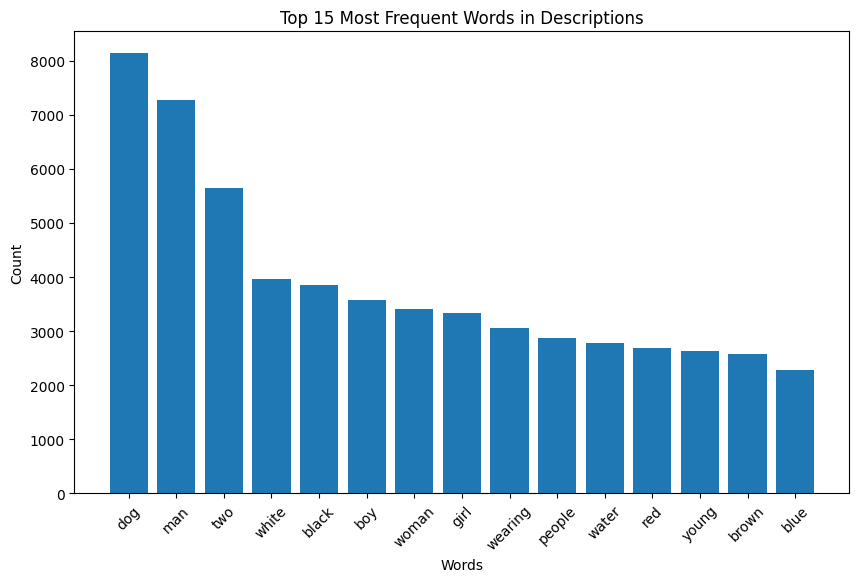

In [6]:
import nltk
nltk.download('stopwords')

# Tokenize the words in the descriptions
descriptions = " ".join(df['Caption'].values)
words = re.findall(r'\w+', descriptions.lower())  # Convert to lowercase and extract words

# Remove stopwords (like 'the', 'and', etc.)
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_words)

# Get the 15 most common words
most_common_words = word_counts.most_common(15)

# Separate the words and their counts
words, counts = zip(*most_common_words)

# Plot a bar chart of the most frequent words
plt.figure(figsize=(10,6))
plt.bar(words, counts)
plt.title('Top 15 Most Frequent Words in Descriptions')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Model Building

In [7]:
print(torch.cuda.is_available())  # Should return True if GPU is detected
print(torch.cuda.device_count())  # Should show the number of GPUs available
print(torch.cuda.get_device_name(0))  # Should display the GPU model


True
1
NVIDIA GeForce GTX 1650


In [8]:
# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
# df = df[:200]
# df


In [10]:
class ProcessDataset(Dataset):
    def __init__(self, df, tokenizer, feature_extractor, decoder_max_length=20):
        """
        Constructor for the dataset class.

        Args:
        - df (pd.DataFrame): DataFrame containing image URLs and captions.
        - tokenizer (AutoTokenizer): Tokenizer for processing captions.
        - feature_extractor: Vision model for extracting image features.
        - decoder_max_length (int): Maximum length of the output caption.
        """
        self.df = df
        self.tokenizer = tokenizer  # This is for the language model
        self.feature_extractor = feature_extractor  # This is for the vision model
        self.decoder_max_length = decoder_max_length  # This is for the caption output

    def __len__(self):
        """
        Returns the length of the dataset.

        This is necessary so that HuggingFace won't complain that the dataset doesn't have __len__ method 
        when it starts training.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Returns a single data item (image and its corresponding caption) at the specified index.

        Args:
        - idx (int): Index of the data item to retrieve.

        Returns:
        - encoding (dict): A dictionary containing the processed image and caption.
        """
        # Get file name + text
        img_path = self.df["Image Name"][idx]
        caption = self.df["Caption"][idx]

        # Process image
        if os.path.exists(img_path):  # Ensure the path exists
            image = Image.open(img_path)
            pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        else:
            raise FileNotFoundError(f"Image path {img_path} does not exist.")

        # Labels here refer to each token in the caption
        labels = self.tokenizer(caption,
                                truncation=True,
                                padding="max_length",
                                max_length=self.decoder_max_length).input_ids

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create a dictionary containing processed image and caption
        encoding = {
            "pixel_values": pixel_values.squeeze().to(device),
            "labels": torch.tensor(labels).to(device)
        }
        return encoding

In [11]:
# Instantiate a GPT-2 tokenizer from Hugging Face's transformers library
# The model is pretrained on GPT-2 architecture with fast tokenization
# The `cache_dir` parameter specifies the directory for caching models
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", cache_dir=".//Model/"+"Pre_trained_models")

# GPT-2 tokenizer doesn't have a pad token by default, so we set it to the eos_token
# This ensures consistent handling of padding during tokenization
tokenizer.pad_token = tokenizer.eos_token

# Instantiate a Vision Transformer (ViT) feature extractor from Hugging Face's transformers library
# The ViT model used is pretrained on images and is specified by the model identifier "google/vit-base-patch16-224-in21k"
# The `cache_dir` parameter specifies the directory for caching models
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k", cache_dir=".//Model/"+"Pre_trained_models")


c:\Users\tanus\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\tanus\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [12]:
# The dataset is limited to the first 2000 samples for training
# The 'tokenizer' and 'feature_extractor' objects are passed as arguments for text and vision processing
train_dataset = ProcessDataset(
    df=df,  
    tokenizer=tokenizer,  # The tokenizer object for processing captions
    feature_extractor=feature_extractor  # The feature extractor object for processing images
)

In [13]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_pretrained_model_name_or_path="google/vit-base-patch16-224-in21k",  # ViT encoder model
    decoder_pretrained_model_name_or_path="gpt2",  # GPT-2 decoder model
    tie_encoder_decoder=True,  # Tie encoder and decoder weights for joint training
    cache_dir=".//Model/"+"Pre_trained_models"  # Directory for caching models
)

c:\Users\tanus\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.2.crossattention.bias', 'h.11.crossattention.bias', 'h.7.crossattention.c_proj.bias', 'h.1.crossattention.q_attn.weight', 'h.7.crossattention.q_attn.weight', 'h.8.crossattention.c_proj.bias', 'h.0.ln_cross_attn.weight', 'h.9.crossattention.q_attn.weight', 'h.6.crossattention.c_proj.bias', 'h.9.crossattention.c_proj.bias', 'h.11.crossattention.q_attn.weight', 'h.0.crossattention.bias', 'h.11.ln_cross_attn.weight', 'h.3.crossattention.c_attn.weight', 'h.9.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.weight', 'h.7.crossattention.c_proj.weight', 'h.8

In [14]:
# Set GPT-2 specific configuration in the VisionEncoderDecoderModel

# GPT-2 only has bos/eos tokens but not decoder_start/pad tokens
# Set decoder_start_token_id, pad_token_id, and eos_token_id using tokenizer values
model.config.decoder_start_token_id = tokenizer.bos_token_id  # Set the beginning-of-sequence token
model.config.pad_token_id = tokenizer.pad_token_id  # Set the pad token for padding sequences
model.config.eos_token_id = tokenizer.eos_token_id  # Set the end-of-sequence token

# Adjust additional model configuration settings
model.config.vocab_size = model.config.decoder.vocab_size  # Match the vocabulary size for consistency
model.config.early_stopping = True  # Enable early stopping during training
model.config.no_repeat_ngram_size = 3  # Set the size of N-gram sequences that cannot be repeated
model.config.length_penalty = 2.0  # Set the length penalty for generated sequences

# Configuration settings specific to the decoder
model.decoder.num_beams = 4  # Set the number of beams used in beam search during decoding
model.decoder.max_length = 20  # Set the maximum length for generated sequences

In [ ]:
# Set batch size and number of training epochs
BATCH_SIZE = 8
TRAIN_EPOCHS = 20

# Define the output directory for storing training outputs
output_directory = os.path.join(".//Model/", "captioning_outputs")

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Set up training arguments for the Trainer
training_args = TrainingArguments(
    output_dir=output_directory,  # Directory to save model checkpoints and logs
    per_device_train_batch_size=BATCH_SIZE,  # Number of training samples per device batch
    do_train=True,  # Perform training
    num_train_epochs=TRAIN_EPOCHS,  # Number of training epochs (passes through the entire dataset)
    overwrite_output_dir=True,  # Overwrite the output directory if it exists
    logging_dir='./logs',
    logging_steps=5,
    no_cuda=False,
    dataloader_pin_memory=False  # Specify whether to pin memory in data loaders
)

# Instantiate a Trainer for training the captioning model
class CustomTrainer(Trainer):
    def log(self, logs):
        super().log(logs)  # Call the base log method to retain default logging
        # Print logs only if 'step' and 'loss' are in the logs
        if 'step' in logs:
            print(f"Step: {logs['step']}", end=" ")
        if 'loss' in logs:
            print(f"- Loss: {logs['loss']}")
        
trainer = CustomTrainer(
    tokenizer=feature_extractor,  # Tokenizer for processing captions
    model=model,  # Model to be trained
    args=training_args,  # Training arguments
    train_dataset=train_dataset,  # Training dataset
    data_collator=default_data_collator,   # Data collator for handling batches
)

cuda


In [ ]:
trainer.train()

c:\Users\tanus\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/101140 [00:00<?, ?it/s]

{'loss': 5.5028, 'learning_rate': 4.9997528178762116e-05, 'epoch': 0.0}
- Loss: 5.5028
{'loss': 2.6335, 'learning_rate': 4.999505635752423e-05, 'epoch': 0.0}
- Loss: 2.6335
{'loss': 2.234, 'learning_rate': 4.9992584536286336e-05, 'epoch': 0.0}
- Loss: 2.234
{'loss': 2.4457, 'learning_rate': 4.999011271504845e-05, 'epoch': 0.0}
- Loss: 2.4457
{'loss': 2.2748, 'learning_rate': 4.9987640893810564e-05, 'epoch': 0.0}
- Loss: 2.2748
{'loss': 2.012, 'learning_rate': 4.998516907257268e-05, 'epoch': 0.01}
- Loss: 2.012
{'loss': 2.141, 'learning_rate': 4.9982697251334784e-05, 'epoch': 0.01}
- Loss: 2.141


In [ ]:
test_image = Image.open("Dataset/Images/3472485022_5d03e9852d.jpg")

# Display the test image using the 'display' function
display(test_image)

In [ ]:
# Assuming the image is preprocessed using the feature_extractor
# Get the image tensor (pixel values)
input_image = feature_extractor(test_image, return_tensors="pt").pixel_values.to(device)  # Ensure it is on the correct device (GPU if available)

print(input_image.shape)
# Use the model to generate caption (generate() is the method for text generation)
# Set the maximum length of the generated caption
generated_caption_ids = model.generate(pixel_values=input_image, max_length=20, num_beams=4, early_stopping=True)

# Decode the generated caption IDs
caption = tokenizer.decode(generated_caption_ids[0], skip_special_tokens=True)

# Print the generated caption
print("Generated Caption:")
print(caption)

# Print a visual separator for clarity
print("--" * 20)


In [ ]:
# Save the trained model
trainer.save_model(output_dir="./Model/Saved_Trained_Model")

# Optionally, save the tokenizer as well (useful for later use in inference or fine-tuning)
trainer.tokenizer.save_pretrained("./Model/Saved_Trained_Model")

In [ ]:
# Calling the Saved model
from transformers import VisionEncoderDecoderModel, GPT2Tokenizer

# Load the saved model
model = VisionEncoderDecoderModel.from_pretrained("./Model/Saved_Trained_Model")

# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("./Model/Saved_Trained_Model")